# Plain Vanilla Interest Rate Swap

# 💼 Interest Rate Swap Pricing and Fixed Rate Optimization

This script calculates the **fair fixed rate** for a plain vanilla interest rate swap by equating the present value (PV) of the fixed leg and the floating leg at inception.

---

## 📌 Parameters

```python
notional = 10000000          # Notional amount of the swap
payment_frequency = 4        # Quarterly payments
tenor_years = 5              # Swap maturity in years
n_periods = tenor_years * payment_frequency
obs_date = '09-07-1990'      # Observation date for market data


In [185]:
# Import libraries
import numpy as np
import pandas as pd
from scipy import optimize

In [186]:
# I will calculate the discount factors from it
bond_yield = pd.read_csv('bonds_yield.csv')
bond_yield.head()

,observation_date,THREEFY1,THREEFY2,THREEFY3,THREEFY4,THREEFY5,THREEFY6,THREEFY7,THREEFY8,THREEFY9,THREEFY10
0,09-07-1990,8.0977,8.2441,8.3033,8.3336,8.3591,8.3887,8.4244,8.4659,8.5119,8.5610
1,10-07-1990,8.1211,8.2659,8.3234,8.3521,8.3763,8.4047,8.4396,8.4803,8.5256,8.5742
2,11-07-1990,8.1166,8.2593,8.3161,8.3448,8.3692,8.3979,8.4330,8.4740,8.5196,8.5684
3,12-07-1990,8.0158,8.1511,8.2106,8.2455,8.2769,8.3121,8.3529,8.3988,8.4486,8.5009
4,13-07-1990,7.9385,8.0757,8.1409,8.1822,8.2195,8.2599,8.3051,8.3547,8.4075,8.4624


In [187]:
import pandas as pd

# Read the CSV file
bond_yield = pd.read_csv('bonds_yield.csv')

# Set 'observation_date' as the index
bond_yield.set_index('observation_date', inplace=True)

# Convert index to datetime
bond_yield.index = pd.to_datetime(bond_yield.index, format='%d-%m-%Y')

# Rename columns to '1Y', '2Y', ..., '10Y'
bond_yield = bond_yield.rename(columns={'THREEFY1': '1Y', 
                        'THREEFY2': '2Y', 
                        'THREEFY3': '3Y', 
                        'THREEFY4': '4Y', 
                        'THREEFY5': '5Y', 
                        'THREEFY6': '6Y', 
                        'THREEFY7': '7Y', 
                        'THREEFY8': '8Y',
                        'THREEFY9': '9Y', 
                        'THREEFY10': '10Y'})

# Format index to desired string format
bond_yield.index = bond_yield.index.strftime('%d-%m-%Y')

# Convert bond_yield from percentage to decimal
bond_yield = bond_yield/100 

# Display the cleaned DataFrame
print(bond_yield.head())


                        1Y        2Y        3Y        4Y        5Y        6Y  \
observation_date                                                               
09-07-1990        0.080977  0.082441  0.083033  0.083336  0.083591  0.083887   
10-07-1990        0.081211  0.082659  0.083234  0.083521  0.083763  0.084047   
11-07-1990        0.081166  0.082593  0.083161  0.083448  0.083692  0.083979   
12-07-1990        0.080158  0.081511  0.082106  0.082455  0.082769  0.083121   
13-07-1990        0.079385  0.080757  0.081409  0.081822  0.082195  0.082599   

                        7Y        8Y        9Y       10Y  
observation_date                                          
09-07-1990        0.084244  0.084659  0.085119  0.085610  
10-07-1990        0.084396  0.084803  0.085256  0.085742  
11-07-1990        0.084330  0.084740  0.085196  0.085684  
12-07-1990        0.083529  0.083988  0.084486  0.085009  
13-07-1990        0.083051  0.083547  0.084075  0.084624  


In [188]:
def calculate_df(data):
    discount_factors = data.copy()
    for i in range(len(discount_factors.columns)):
        col = discount_factors.columns[i]
        discount_factors[col] = 1 / (1 + discount_factors[col]) ** (i + 1)
        return discount_factors

discount_factors = calculate_df(bond_yield)
discount_factors.head()

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
observation_date,,,,,,,,,,
09-07-1990,0.925089,0.082441,0.083033,0.083336,0.083591,0.083887,0.084244,0.084659,0.085119,0.085610
10-07-1990,0.924889,0.082659,0.083234,0.083521,0.083763,0.084047,0.084396,0.084803,0.085256,0.085742
11-07-1990,0.924927,0.082593,0.083161,0.083448,0.083692,0.083979,0.084330,0.084740,0.085196,0.085684
12-07-1990,0.925790,0.081511,0.082106,0.082455,0.082769,0.083121,0.083529,0.083988,0.084486,0.085009
13-07-1990,0.926453,0.080757,0.081409,0.081822,0.082195,0.082599,0.083051,0.083547,0.084075,0.084624


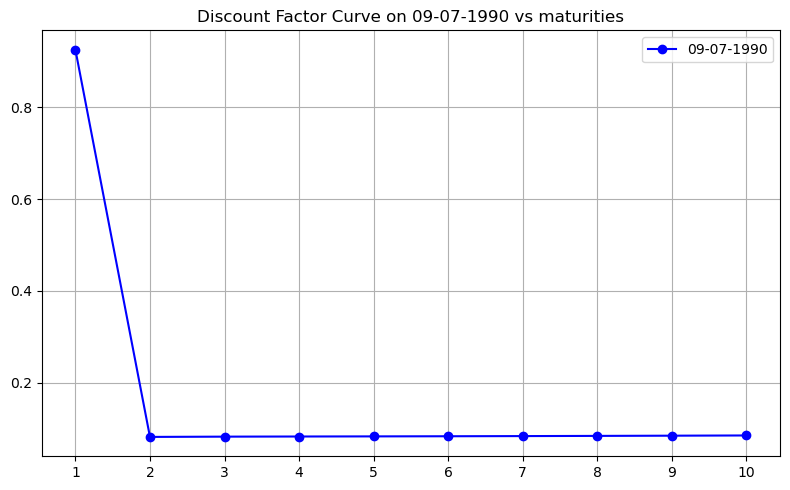

In [189]:
# Select a single observation date
selected_date = '09-07-1990'
df_single_date = discount_factors.loc[selected_date] # Creates a Series (1D array) of discount factors across maturities for the given date

# Plot the discount curve
plt.figure(figsize=(8, 5)) 
plt.plot(range(1, 11), df_single_date.values, marker='o', color='blue', label=selected_date)

# Add labels and title
#plt.xlabel('Time')
#plt.ylabel('Discount factors')

plt.title(f'Discount Factor Curve on {selected_date} vs maturities')
plt.grid(True)
plt.xticks(range(1, 11))
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()



### Preprocessing the Forward Rate Curve

In [190]:
forward_rate = pd.read_csv('forward_rate.csv')
forward_rate.head()

,observation_date,THREEFF1,THREEFF2,THREEFF3,THREEFF4,THREEFF5,THREEFF6,THREEFF7,THREEFF8,THREEFF9,THREEFF10
0,1990-07-09,8.3225,8.4215,8.4196,8.4360,8.4933,8.5842,8.6961,8.8179,8.9419,9.0630
1,1990-07-10,8.3446,8.4399,8.4347,8.4487,8.5043,8.5941,8.7052,8.8266,8.9502,9.0711
2,1990-07-11,8.3369,8.4309,8.4266,8.4418,8.4984,8.5890,8.7006,8.8223,8.9462,9.0672
3,1990-07-12,8.2196,8.3212,8.3366,8.3700,8.4401,8.5400,8.6578,8.7835,8.9100,9.0328
4,1990-07-13,8.1406,8.2548,8.2858,8.3317,8.4107,8.5165,8.6381,8.7662,8.8942,9.0181


In [191]:
# Set 'observation_date' as index
forward_rate.set_index('observation_date', inplace=True)

# Convert index to datetime format
forward_rate.index = pd.to_datetime(forward_rate.index, format='%Y-%m-%d')

# Format index to desired string format
forward_rate.index = forward_rate.index.strftime('%d-%m-%Y')

# Convert forward_rate from percentage to decimal
forward_rate = forward_rate/100

# Display the first few rows
forward_rate.head()


,THREEFF1,THREEFF2,THREEFF3,THREEFF4,THREEFF5,THREEFF6,THREEFF7,THREEFF8,THREEFF9,THREEFF10
observation_date,,,,,,,,,,
09-07-1990,0.083225,0.084215,0.084196,0.084360,0.084933,0.085842,0.086961,0.088179,0.089419,0.090630
10-07-1990,0.083446,0.084399,0.084347,0.084487,0.085043,0.085941,0.087052,0.088266,0.089502,0.090711
11-07-1990,0.083369,0.084309,0.084266,0.084418,0.084984,0.085890,0.087006,0.088223,0.089462,0.090672
12-07-1990,0.082196,0.083212,0.083366,0.083700,0.084401,0.085400,0.086578,0.087835,0.089100,0.090328
13-07-1990,0.081406,0.082548,0.082858,0.083317,0.084107,0.085165,0.086381,0.087662,0.088942,0.090181


### Pricing Interest rate swap

### Market data extraction till tenor_years
```python
dfs = discount_factors.loc[obs_date].values[:tenor_years]
fwd_rates = forward_rate.loc[obs_date].values[:tenor_years]
```

### Interpolation of Quarterly Discount Factors: This interpolates annual discount factors into quarterly ones using linear interpolation.

$
DF_q = DF_i + \left( \frac{DF_{i+1} - DF_i}{m} \right) \times j
$


- \( DF_q \) is the interpolated discount factor for quarter \( j \)
- \( DF_i \) is the discount factor at the beginning of year \( i \)
- \( DF_{i+1} \) is the discount factor at the end of year \( i \)
- \( m \) is the number of quarters in a year (i.e., \( m = 4 \))
- \( j = \{0, 1, 2, 3\} \) represents the quarter within year \( i \)


```python
quarterly_dfs = []
for i in range(tenor_years):
    start = dfs[i]
    end = dfs[i + 1] if i + 1 < len(dfs) else dfs[i]
    step = (end - start) / payment_frequency
    quarterly_dfs.extend([start + step * j for j in range(payment_frequency)])
```

### Floating Leg Cash Flows: Each floating cash flow is calculated as:

$
\text{Floating Cash Flow = Notional × Forward Rate/Payment Frequency}
$
 
```python
floating_cash_flows = []
for i in range(tenor_years):
    for j in range(payment_frequency):
        floating_cash_flows.append(notional * (fwd_rates[i]) / payment_frequency)
```
### Present Value Function: Calculates the present value of a stream of cash flows using corresponding discount factors.

$
PV = \sum_{t=1}^{n} CF_t \cdot DF_t
$


- \( PV \) is the present value of the cash flows
- \( CF_t \) is the cash flow at time \( t \)
- \( DF_t \) is the discount factor applicable at time \( t \)
- \( n \) is the total number of periods


In [194]:
# Parameters
notional = 10000000
payment_frequency = 4  # Quarterly
tenor_years = 5
n_periods = tenor_years * payment_frequency

# Choose a specific observation date
obs_date = '09-07-1990'

# Extract discount factors and forward rates for the selected date
dfs = discount_factors.loc[obs_date].values[:tenor_years]
fwd_rates = forward_rate.loc[obs_date].values[:tenor_years]

# Interpolate quarterly discount factors
quarterly_dfs = []
for i in range(tenor_years):
    start = dfs[i]
    end = dfs[i + 1] if i + 1 < len(dfs) else dfs[i]
    step = (end - start) / payment_frequency
    quarterly_dfs.extend([start + step * j for j in range(payment_frequency)])

# Generate floating leg cash flows
floating_cash_flows = []
for i in range(tenor_years):
    for j in range(payment_frequency):
        floating_cash_flows.append(notional * (fwd_rates[i]) / payment_frequency) # Note fwd_rates are already converted to decimal from percentage

# Present value function
def present_value(cash_flows, discount_factors):
    return sum(cf * df for cf, df in zip(cash_flows, discount_factors))

# Objective: minimize difference between PVs
def objective(fixed_rate):
    fixed_cash_flows = [notional * fixed_rate / payment_frequency] * n_periods
    pv_fixed = present_value(fixed_cash_flows, quarterly_dfs)
    pv_floating = present_value(floating_cash_flows, quarterly_dfs)
    return abs(pv_fixed - pv_floating)

# Optimize fixed rate
result = minimize_scalar(objective, bounds=(0.0, 0.1), method='bounded')
fair_fixed_rate = result.x

# Output
print(f"Fair Fixed Rate: {fair_fixed_rate * 100:.4f}%")


Fair Fixed Rate: 8.3651%
